In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
import os

In [122]:
data = []
dirs = ['bench', 'out1', 'out2', 'out3', 'out4', 'out5', 'out6', 'out7']
for d in dirs:
	data.append(pd.read_csv(d + '/experiment.csv'))

In [123]:
if not os.path.exists('plots'):
	os.makedirs('plots')

In [124]:
def plot(data, title='Average payouts with standard deviation'):
	treatments = data['treatment'].unique()
	num_treatments = len(treatments)

	averages = pd.DataFrame(index=range(1, 76), columns=treatments)
	stds = pd.DataFrame(index=range(1, 76), columns=treatments)

	for treatment in treatments:
		round_averages = []
		round_stds = []
		for round in range(1, 76):
			round_df = data.loc[(data['treatment'] == treatment) & (data['round'] == round), ['player1_payout', 'player2_payout']].reset_index(drop=True)
			round_averages.append(((round_df['player1_payout'] + round_df['player2_payout']) / 2).mean())
			round_stds.append(((round_df['player1_payout'] + round_df['player2_payout']) / 2).std())
		averages[treatment] = round_averages
		stds[treatment] = round_stds

	sns.set_theme(style="whitegrid")

	n_cols = 3
	n_rows = math.ceil(num_treatments / n_cols)

	fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
	axs = axs.flatten()

	plt.setp(axs, xlim=(1, 75), ylim=(0, 50))

	min_payoff = {
		0.6: 12,
		1: 20,
		2: 17.5
	}

	for i, treatment in enumerate(treatments):
		mean_vals = averages[treatment]
		std_vals = stds[treatment]
		sns.lineplot(x=mean_vals.index, y=mean_vals, ax=axs[i], label='Average Payout')

		sns.lineplot(x=range(1, 76), y=[45] * 75, ax=axs[i], color='r', linestyle='--', label='Payout Dominant Eq')
		sns.lineplot(x=range(1, 76), y=[36] * 75, ax=axs[i], color='y', linestyle='--', label='Mixed Eq')
		sns.lineplot(x=range(1, 76), y=[min_payoff[treatment]] * 75, ax=axs[i], color='g', linestyle='--', label='Risk Dominant Eq')

		axs[i].fill_between(mean_vals.index, mean_vals - std_vals, mean_vals + std_vals, color='b', alpha=0.2)
		axs[i].set_title(treatment)
		axs[i].set_xlabel('Round number')
		axs[i].set_ylabel('Average Payout')
		axs[i].legend(loc='lower right')

	for j in range(len(treatments), len(axs)):
		fig.delaxes(axs[j])

	fig.suptitle(title, fontsize=16)
	plt.tight_layout(rect=[0, 0, 1, 0.96])
	plt.savefig(f'plots/plot_exp{title[-1]}.png')
	plt.show()

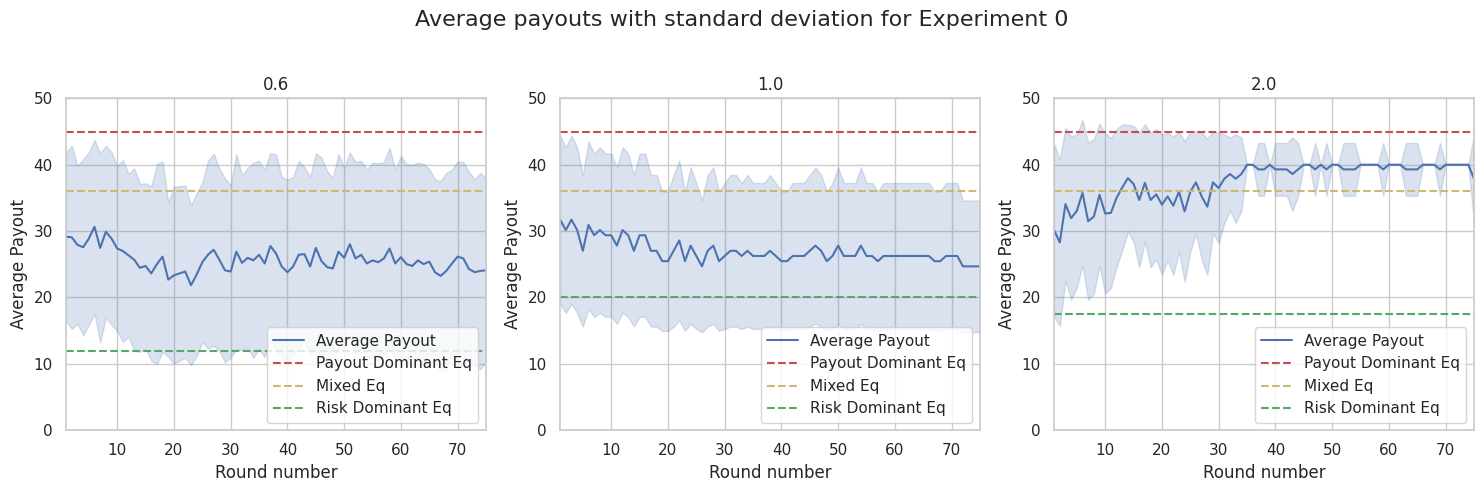

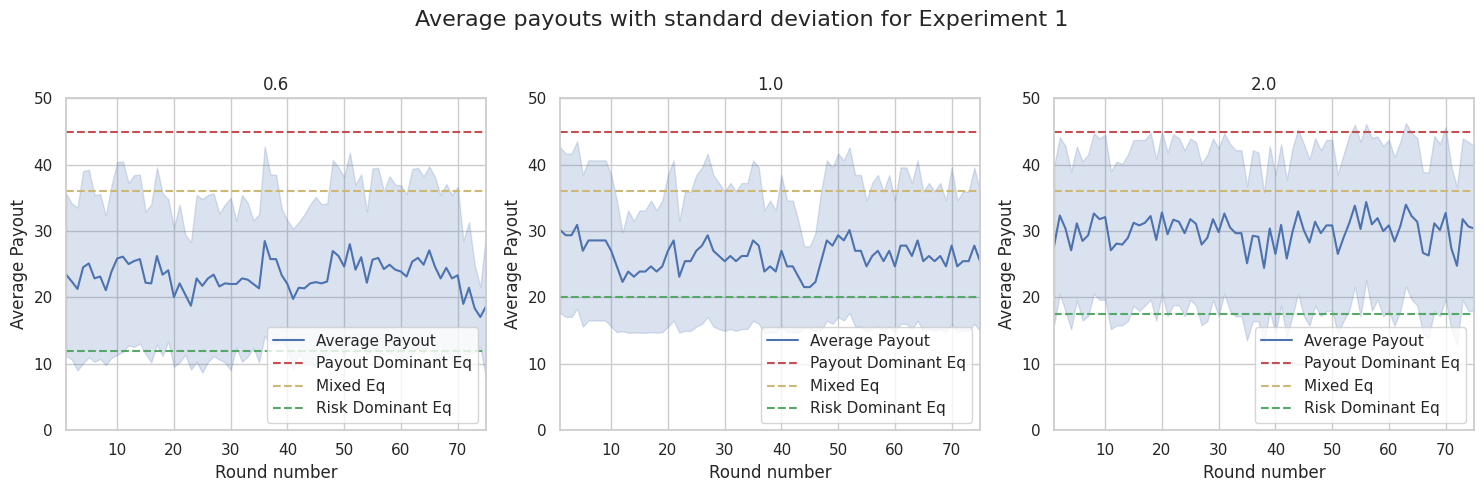

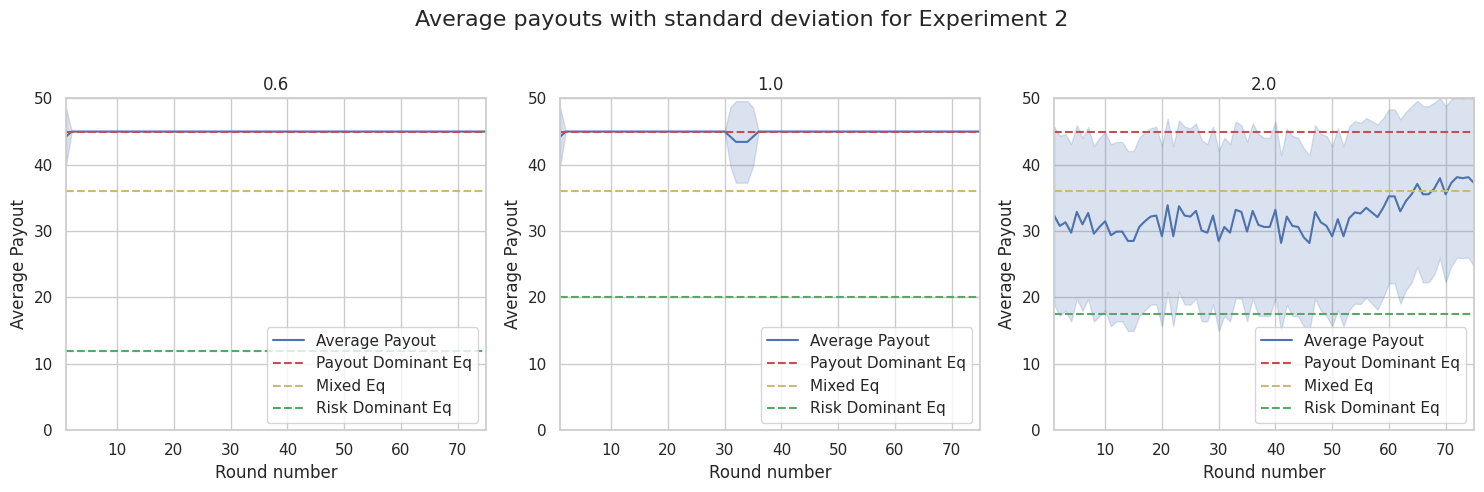

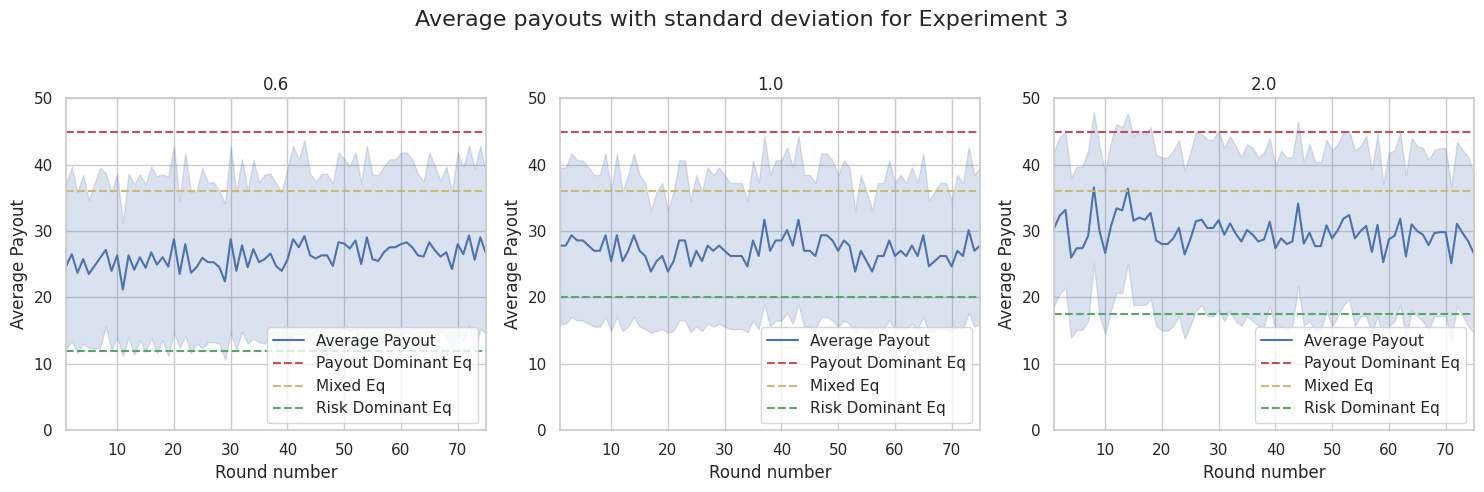

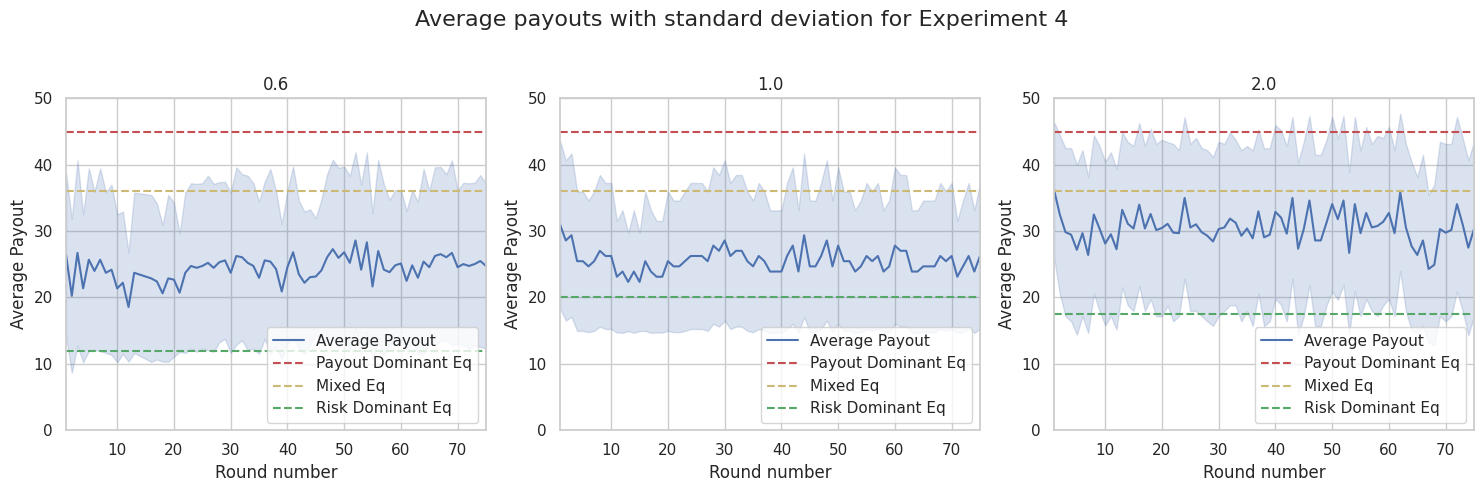

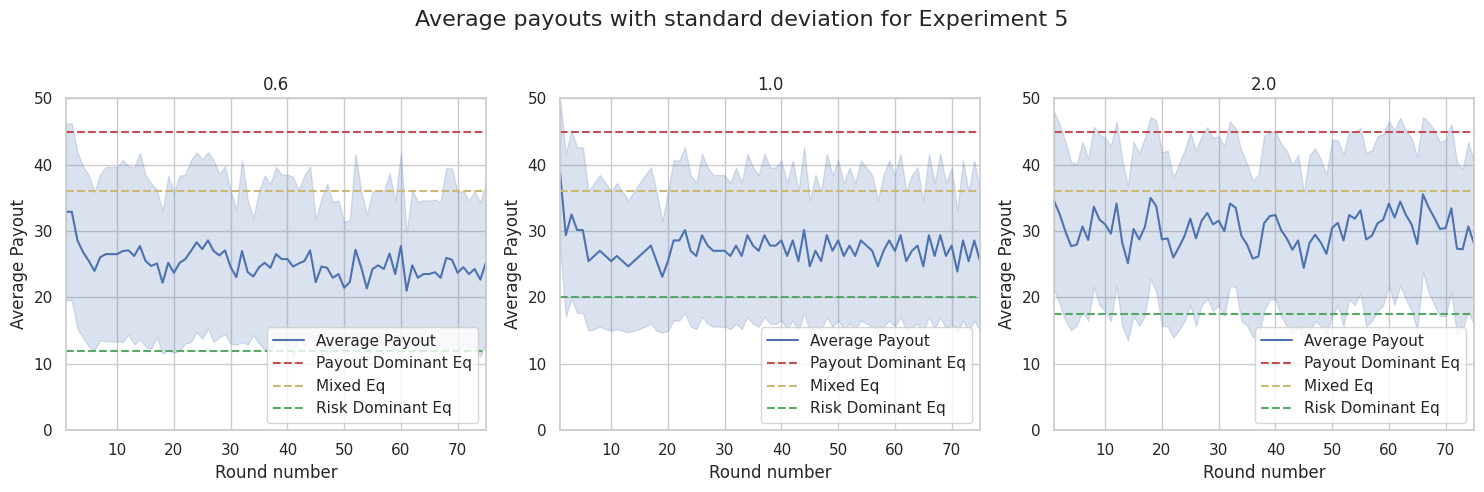

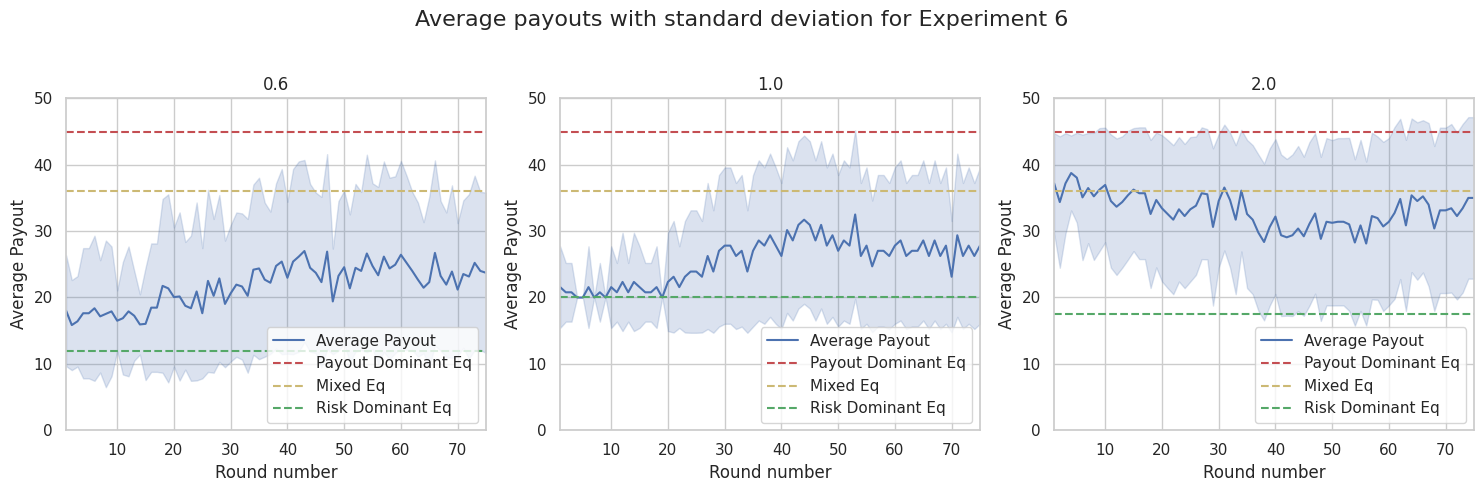

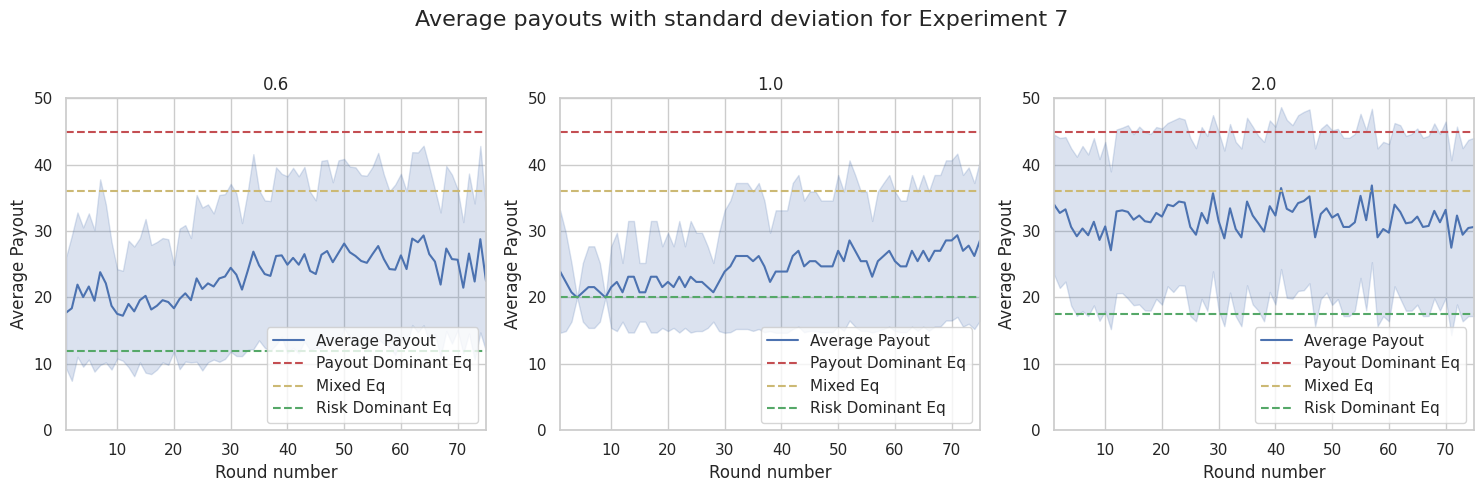

In [125]:
for i, d in enumerate(data):
	plot(d, title=f"Average payouts with standard deviation for Experiment {i}")

In [126]:
def compute_averages(data, treatments):
	averages = pd.DataFrame(index=range(1, 76), columns=treatments)

	for treatment in treatments:
			round_averages = []
			for round in range(1, 76):
				round_df = data.loc[(data['treatment'] == treatment) & (data['round'] == round), ['player1_payout', 'player2_payout']].reset_index(drop=True)
				round_averages.append(((round_df['player1_payout'] + round_df['player2_payout']) / 2).mean())
			averages[treatment] = round_averages
	
	return averages

In [127]:
base_df = data[0]
treatments = base_df['treatment'].unique()
num_treatments = len(treatments)

base_averages = compute_averages(base_df, treatments)

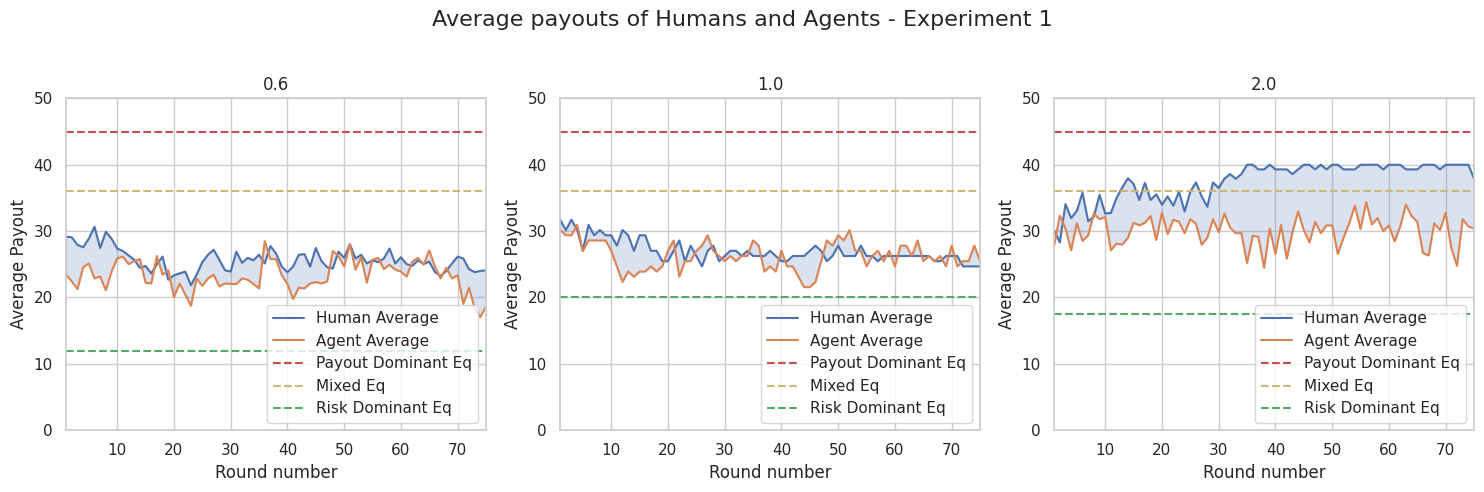

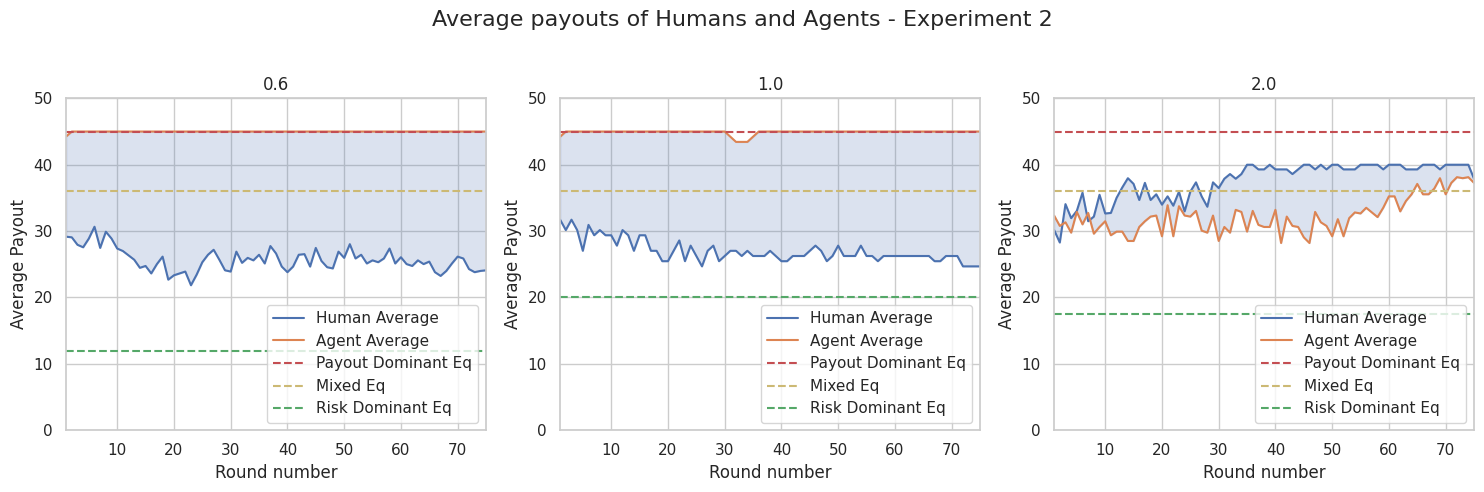

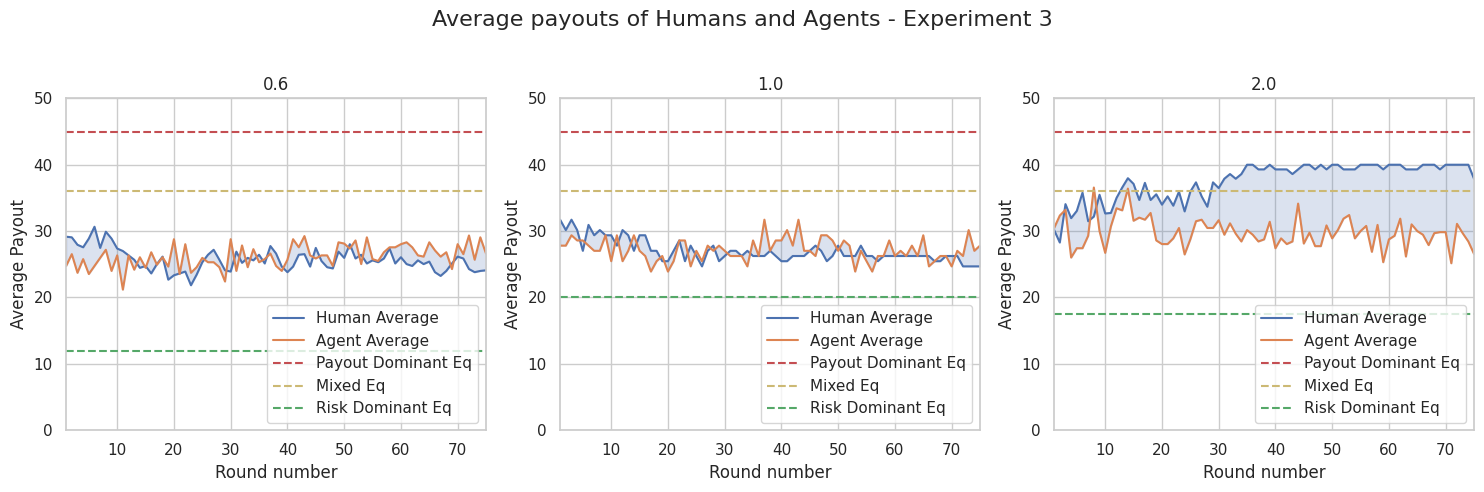

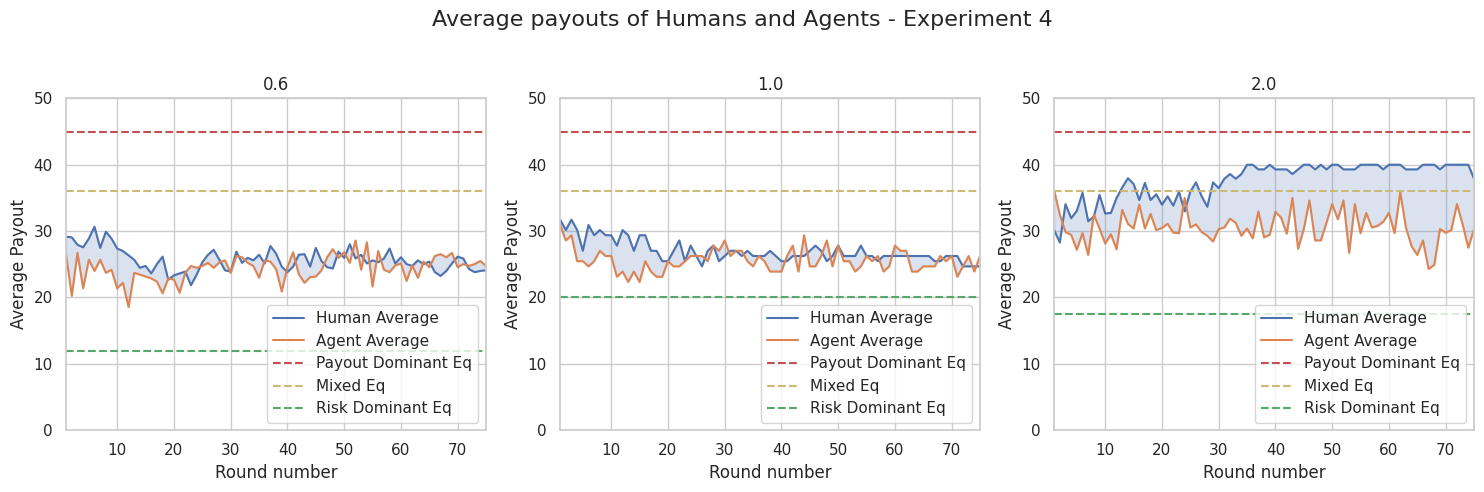

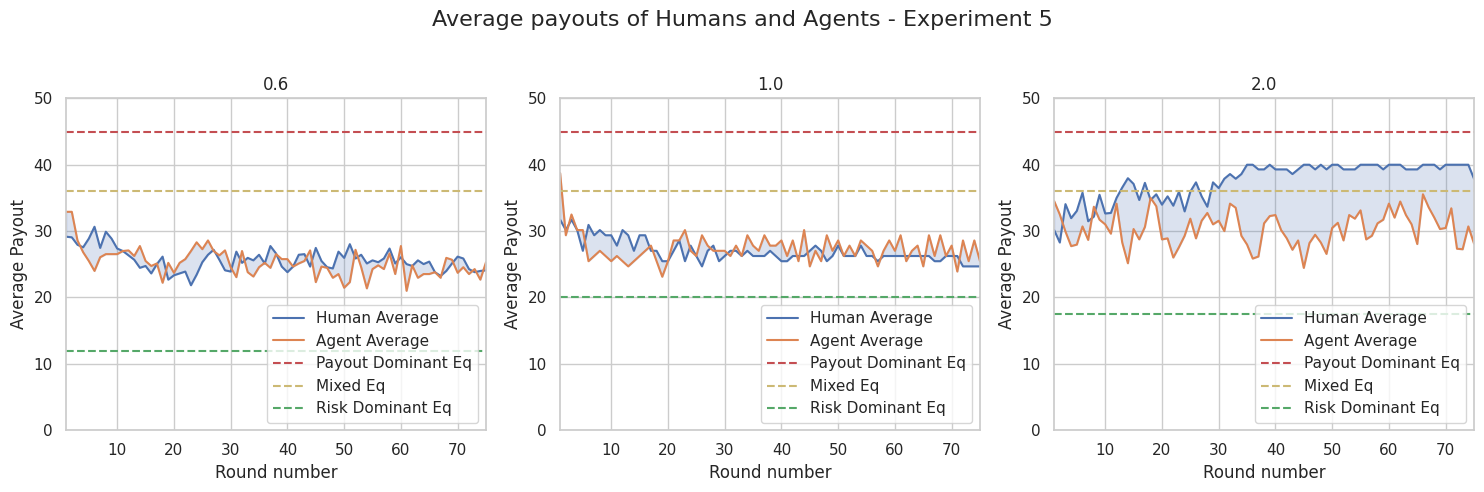

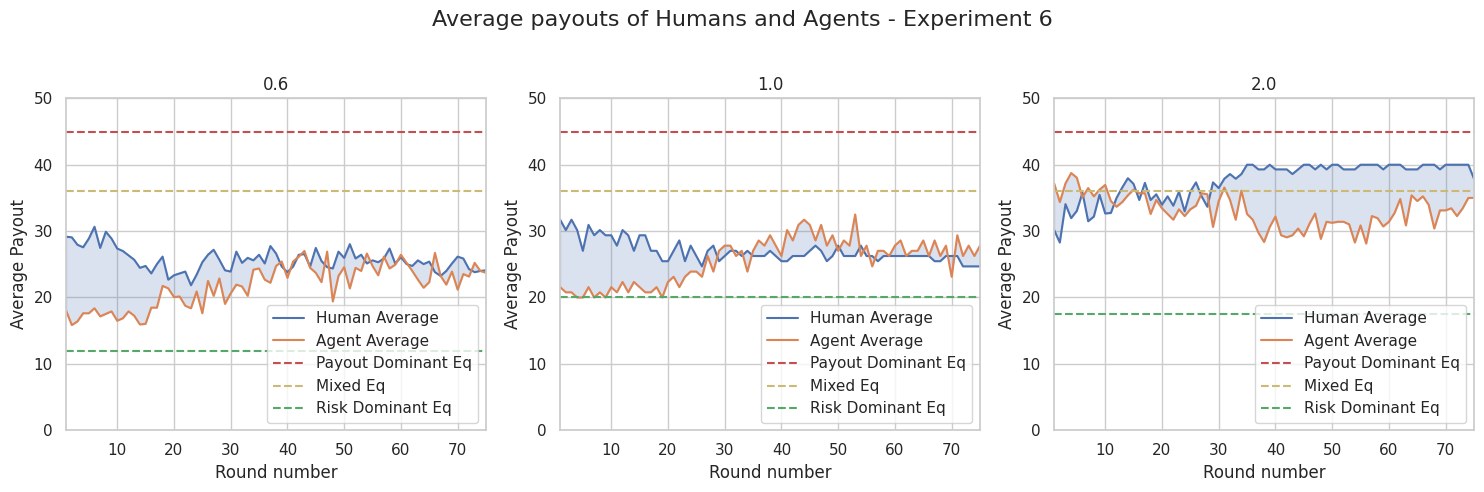

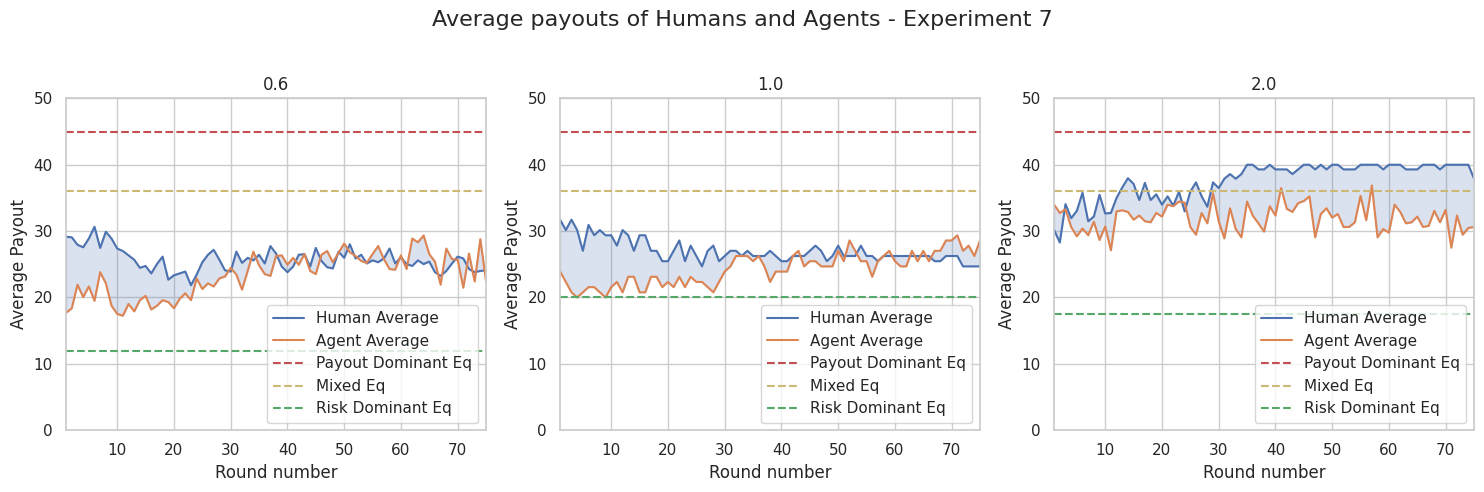

In [128]:
for idx, exp_df in enumerate(data[1:]):
	exp_averages = compute_averages(exp_df, treatments)
	
	fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
	plt.setp(axs, xlim=(1, 75), ylim=(0, 50))

	min_payoff = {
		0.6: 12,
		1: 20,
		2: 17.5
	}

	for i, treatment in enumerate(treatments):
		base_vals = base_averages[treatment]
		mean_vals = exp_averages[treatment]
		
		sns.lineplot(x=base_vals.index, y=base_vals, ax=axs[i], label='Human Average')
		sns.lineplot(x=mean_vals.index, y=mean_vals, ax=axs[i], label='Agent Average')
		axs[i].fill_between(mean_vals.index, mean_vals, base_vals, color='b', alpha=0.2)

		sns.lineplot(x=range(1, 76), y=[45] * 75, ax=axs[i], color='r', linestyle='--', label='Payout Dominant Eq')
		sns.lineplot(x=range(1, 76), y=[36] * 75, ax=axs[i], color='y', linestyle='--', label='Mixed Eq')
		sns.lineplot(x=range(1, 76), y=[min_payoff[treatment]] * 75, ax=axs[i], color='g', linestyle='--', label='Risk Dominant Eq')

		axs[i].set_title(treatment)
		axs[i].set_xlabel('Round number')
		axs[i].set_ylabel('Average Payout')
		axs[i].legend(loc='lower right')
	
	fig.suptitle(f'Average payouts of Humans and Agents - Experiment {idx+1}', fontsize=16)
	plt.tight_layout(rect=[0, 0, 1, 0.96])
	plt.savefig(f'plots/comp_plot_exp{idx+1}.png')

In [129]:
for exp_df in data[1:]:
	exp_averages = compute_averages(exp_df, treatments)

	for treatment in treatments:
		print(stats.pearsonr(base_averages[treatment], exp_averages[treatment]))
	print("")
	

PearsonRResult(statistic=0.26027880438700834, pvalue=0.02411802042002431)
PearsonRResult(statistic=0.1959560086045952, pvalue=0.09200720666814842)
PearsonRResult(statistic=-0.070293086651276, pvalue=0.5489906007759946)

PearsonRResult(statistic=-0.23467218521512315, pvalue=0.042705250826022674)
PearsonRResult(statistic=-0.05075027207857686, pvalue=0.6654455668547878)
PearsonRResult(statistic=0.34048251388804884, pvalue=0.0027989705921143975)

PearsonRResult(statistic=-0.12097975150054435, pvalue=0.3011728635588272)
PearsonRResult(statistic=0.05673068382947609, pvalue=0.6287834267793811)
PearsonRResult(statistic=-0.14432207500242847, pvalue=0.21669934329600765)

PearsonRResult(statistic=-0.07958756000437553, pvalue=0.4972964239096916)
PearsonRResult(statistic=0.15889570558103175, pvalue=0.17331375359402557)
PearsonRResult(statistic=-0.05255923840024244, pvalue=0.6542679497023881)

PearsonRResult(statistic=0.25210120303586714, pvalue=0.029112145661927647)
PearsonRResult(statistic=0.25207

In [130]:
for exp_df in data[1:]:
	exp_averages = compute_averages(exp_df, treatments)

	for treatment in treatments:
		print(stats.spearmanr(base_averages[treatment], exp_averages[treatment]))
	print("")
	

SignificanceResult(statistic=0.2721875026139061, pvalue=0.01815643881836374)
SignificanceResult(statistic=0.07889838067069918, pvalue=0.5010403543909769)
SignificanceResult(statistic=-0.09475098947106705, pvalue=0.4187412776038675)

SignificanceResult(statistic=-0.18801128734347214, pvalue=0.10624169473144743)
SignificanceResult(statistic=-0.12398324278467385, pvalue=0.2892412134808548)
SignificanceResult(statistic=0.36115201807181235, pvalue=0.0014560171202330965)

SignificanceResult(statistic=-0.10227766746572924, pvalue=0.3825723657536847)
SignificanceResult(statistic=0.030883649507645283, pvalue=0.792526889375537)
SignificanceResult(statistic=-0.12849656547588212, pvalue=0.27190579160453915)

SignificanceResult(statistic=-0.05719390413329515, pvalue=0.6259793157346626)
SignificanceResult(statistic=0.002159803611651245, pvalue=0.9853274864625654)
SignificanceResult(statistic=0.0008273013817054497, pvalue=0.9943795063631058)

SignificanceResult(statistic=0.1557705625884722, pvalue=0.